# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# convering image into embeddings
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=192):
        super().__init__()
        # patches are extracted using convolution, 
        self.patches = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size, # non overlapping
                                 padding=0)
        # extracted patches are then flattened into embeddings
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        
    def forward(self, x):
        x = self.patches(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)
        
        
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x
    
# ViT class
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=1000):
        super().__init__()
        # calculating number of patches
        self.num_patches = (img_size*img_size) // patch_size**2
        # creating additional class embedding (token)
        self.class_embedding = nn.Parameter(data=torch.rand(1, 1, embedding_dim), requires_grad=True)
        # creating learnable positional embeddings
        self.pos_embedding = nn.Parameter(data=torch.rand(1, self.num_patches+1, embedding_dim), requires_grad=True)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        # image -> embeddings
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # transformer layers
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        # classification head 
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        # class token
        cls_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x) # embeddings
        x = torch.cat((cls_token, x), dim=1) # embeddings + class token
        x = self.pos_embedding + x # making positional embeddings
        x = self.emb_dropout(x)
        x = self.encoder(x) # transformer layers
        x = self.head(x[:, 0]) # classification is done based on class embedding (token)
        
        return x
        
# ViT_Ti16 configuration                    # compared to original ViT-B it has smaller D size and MLP size
class ViT_Ti_16(ViT):                       # as well as reduced number of heads 
    def __init__(self,                      # having less than 6 mln params. while ViT-B has 86 mln
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
 

#ViT_Ti32 configuration   
class ViT_Ti_32(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=32,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
        
   

# ViT_Lite16 configuration   
class ViT_Lite_16(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=7,
                 embedding_dim: int=256,
                 mlp_size: int=512,
                 num_heads: int=4,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
     

# ViT_Lite32 configuration   
class ViT_Lite_32(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=32,
                 layers: int=7,
                 embedding_dim: int=256,
                 mlp_size: int=512,
                 num_heads: int=4,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = ViT_Lite_16()
model = model.to(config['DEVICE'])
model_name = "vit_lite16"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT_Lite_16 (ViT_Lite_16)                               [32, 3, 224, 224]    [32, 10]             38,016               True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 192]       --                   True
│    └─Conv2d (patches)                                 [32, 3, 224, 224]    [32, 192, 14, 14]    147,648              True
│    └─Flatten (flatten)                                [32, 192, 14, 14]    [32, 192, 196]       --                   --
├─Dropout (emb_dropout)                                 [32, 197, 192]       [32, 197, 192]       --                   --
├─Sequential (encoder)                                  [32, 197, 192]       [32, 197, 192]       --                   True
│    └─EncoderBlock (0)                                 [32, 197, 192]       [32, 197, 192]       --                   True
│    │ 

# Training

Training: 100%|██████████| 281/281 [01:51<00:00,  2.53it/s]


Epoch 1 | Train Loss: 2.3113860803991026 | Accuracy: 0.11739784826355984 | Precision: 0.11356975139348922 | Recall: 0.11739784826355984 | F1: 0.10788426344083972


Validating: 100%|██████████| 71/71 [00:20<00:00,  3.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.3379495916232256 | Accuracy: 0.11750278706800446 | Precision: 0.10241696235120254 | Recall: 0.11750278706800446 | F1: 0.055947867277726354
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.48it/s]


Epoch 2 | Train Loss: 2.2796111895944726 | Accuracy: 0.13846925692625006 | Precision: 0.1367563461340048 | Recall: 0.13846925692625006 | F1: 0.1297796302387199


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.3010516653598194 | Accuracy: 0.1391304347826087 | Precision: 0.1169035762441596 | Recall: 0.1391304347826087 | F1: 0.0852967005524621
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.39it/s]


Epoch 3 | Train Loss: 2.121369638476932 | Accuracy: 0.2057528290317186 | Precision: 0.19837572011816573 | Recall: 0.2057528290317186 | F1: 0.19386859546527752


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.06it/s]


	Validation Loss: 1.8884943790838753 | Accuracy: 0.28561872909699 | Precision: 0.331739860354311 | Recall: 0.28561872909699 | F1: 0.2615191336083608
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 4 | Train Loss: 1.878578822383677 | Accuracy: 0.3011873571548024 | Precision: 0.29407158944896733 | Recall: 0.3011873571548024 | F1: 0.29055679002076723


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.17it/s]


	Validation Loss: 1.6171910594886458 | Accuracy: 0.39531772575250834 | Precision: 0.42851164954698256 | Recall: 0.39531772575250834 | F1: 0.3638531010671094
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 5 | Train Loss: 1.5854704019437906 | Accuracy: 0.41641117119125926 | Precision: 0.4065556501253713 | Recall: 0.41641117119125926 | F1: 0.406493664736787


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.58it/s]


	Validation Loss: 1.4136721567368844 | Accuracy: 0.46488294314381273 | Precision: 0.49385265981039034 | Recall: 0.46488294314381273 | F1: 0.4419932003603912
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


Epoch 6 | Train Loss: 1.334152155075209 | Accuracy: 0.5183120575282903 | Precision: 0.5094659156568165 | Recall: 0.5183120575282903 | F1: 0.5097764283731766


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


	Validation Loss: 1.0666823647391628 | Accuracy: 0.6053511705685619 | Precision: 0.6142216024122968 | Recall: 0.6053511705685619 | F1: 0.5983235138654843
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.62it/s]


Epoch 7 | Train Loss: 1.1094651614643924 | Accuracy: 0.6002564245498634 | Precision: 0.5939131613670362 | Recall: 0.6002564245498634 | F1: 0.5951010395240898


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.8807754911167521 | Accuracy: 0.6956521739130435 | Precision: 0.7124834795570719 | Recall: 0.6956521739130435 | F1: 0.6908095745148447
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 8 | Train Loss: 0.9337711932396126 | Accuracy: 0.6728914655220469 | Precision: 0.668739455187401 | Recall: 0.6728914655220469 | F1: 0.6694196572673276


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


	Validation Loss: 0.7189655354325201 | Accuracy: 0.7609810479375697 | Precision: 0.774633226914987 | Recall: 0.7609810479375697 | F1: 0.7609735537168025
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.57it/s]


Epoch 9 | Train Loss: 0.8013006550561491 | Accuracy: 0.7212776631919282 | Precision: 0.7187182569380451 | Recall: 0.7212776631919282 | F1: 0.7191289315675937


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.8013968140306608 | Accuracy: 0.7346711259754738 | Precision: 0.7599884380688601 | Recall: 0.7346711259754738 | F1: 0.7140272080605404


Training: 100%|██████████| 281/281 [01:19<00:00,  3.54it/s]


Epoch 10 | Train Loss: 0.6903388091889989 | Accuracy: 0.7607447460839512 | Precision: 0.7588792276621076 | Recall: 0.7607447460839512 | F1: 0.7593753088514866


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.5626247814843353 | Accuracy: 0.8131549609810479 | Precision: 0.8274631065244535 | Recall: 0.8131549609810479 | F1: 0.8110605297922251
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 11 | Train Loss: 0.5926431009141576 | Accuracy: 0.7993756619655499 | Precision: 0.7982633259444991 | Recall: 0.7993756619655499 | F1: 0.7983233780845729


Validating: 100%|██████████| 71/71 [00:11<00:00,  5.93it/s]


	Validation Loss: 0.41977734695857677 | Accuracy: 0.8677814938684504 | Precision: 0.8684781820842449 | Recall: 0.8677814938684504 | F1: 0.865303913661819
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 12 | Train Loss: 0.5283753695861301 | Accuracy: 0.8218964267796421 | Precision: 0.8207499255575272 | Recall: 0.8218964267796421 | F1: 0.8210104283336633


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.3871110715496708 | Accuracy: 0.8744704570791527 | Precision: 0.8781978749335291 | Recall: 0.8744704570791527 | F1: 0.8742248964262457
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 13 | Train Loss: 0.464127397781165 | Accuracy: 0.8445286805284575 | Precision: 0.843695369928292 | Recall: 0.8445286805284575 | F1: 0.8439382813005653


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.3473077318827871 | Accuracy: 0.8849498327759198 | Precision: 0.8894172441562834 | Recall: 0.8849498327759198 | F1: 0.8837229694755926
Saving best model at epoch 13...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.51it/s]


Epoch 14 | Train Loss: 0.40895037109105187 | Accuracy: 0.8620324432800045 | Precision: 0.8615717239245856 | Recall: 0.8620324432800045 | F1: 0.8616484748146053


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


	Validation Loss: 0.2915212940162336 | Accuracy: 0.9070234113712374 | Precision: 0.9089219363139684 | Recall: 0.9070234113712374 | F1: 0.9064699978181945
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.67it/s]


Epoch 15 | Train Loss: 0.38575329506948747 | Accuracy: 0.8720664474050951 | Precision: 0.871610009979194 | Recall: 0.8720664474050951 | F1: 0.8717216171641006


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.2826913363287147 | Accuracy: 0.9119286510590858 | Precision: 0.9122672208287076 | Recall: 0.9119286510590858 | F1: 0.9108140087232104
Saving best model at epoch 15...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 16 | Train Loss: 0.34307604182339224 | Accuracy: 0.8846089525614583 | Precision: 0.8842105445285056 | Recall: 0.8846089525614583 | F1: 0.8843176531074605


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


	Validation Loss: 0.25432593585319924 | Accuracy: 0.9181716833890747 | Precision: 0.9201084221813733 | Recall: 0.9181716833890747 | F1: 0.9176461410625439
Saving best model at epoch 16...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


Epoch 17 | Train Loss: 0.3102757108540297 | Accuracy: 0.8953118902948882 | Precision: 0.8951617874702001 | Recall: 0.8953118902948882 | F1: 0.895106400131075


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.12it/s]


	Validation Loss: 0.24110882939167425 | Accuracy: 0.9192865105908584 | Precision: 0.9205947785349576 | Recall: 0.9192865105908584 | F1: 0.9187288660592156
Saving best model at epoch 17...


Training: 100%|██████████| 281/281 [01:24<00:00,  3.31it/s]


Epoch 18 | Train Loss: 0.28673505841413005 | Accuracy: 0.9046212163442778 | Precision: 0.904305733462004 | Recall: 0.9046212163442778 | F1: 0.9043792474110163


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.02it/s]


	Validation Loss: 0.17232413957236517 | Accuracy: 0.9462653288740245 | Precision: 0.9469837093754145 | Recall: 0.9462653288740245 | F1: 0.9464164526401744
Saving best model at epoch 18...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 19 | Train Loss: 0.2714969240579741 | Accuracy: 0.9094709850047383 | Precision: 0.90933513585542 | Recall: 0.9094709850047383 | F1: 0.9093113061597362


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.28it/s]


	Validation Loss: 0.1861374967167495 | Accuracy: 0.9395763656633221 | Precision: 0.94084739544476 | Recall: 0.9395763656633221 | F1: 0.9393391218363657


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 20 | Train Loss: 0.24910616718259146 | Accuracy: 0.9177211661742573 | Precision: 0.9174934650438848 | Recall: 0.9177211661742573 | F1: 0.9175288357898262


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.21it/s]


	Validation Loss: 0.15837138379648538 | Accuracy: 0.9522853957636567 | Precision: 0.9536558138419828 | Recall: 0.9522853957636567 | F1: 0.9524460540772474
Saving best model at epoch 20...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 21 | Train Loss: 0.2200641370116604 | Accuracy: 0.9273649590278165 | Precision: 0.9271873614936926 | Recall: 0.9273649590278165 | F1: 0.9272332774977288


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.1565391289621172 | Accuracy: 0.9502787068004459 | Precision: 0.9516621096262782 | Recall: 0.9502787068004459 | F1: 0.9505546127497532
Saving best model at epoch 21...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 22 | Train Loss: 0.2247590425016617 | Accuracy: 0.9241875243882045 | Precision: 0.924032353614422 | Recall: 0.9241875243882045 | F1: 0.9240428189325


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.24it/s]


	Validation Loss: 0.15576781951625582 | Accuracy: 0.9540691192865106 | Precision: 0.956575512084536 | Recall: 0.9540691192865106 | F1: 0.9544000290397779
Saving best model at epoch 22...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 23 | Train Loss: 0.2049847651418842 | Accuracy: 0.9296504821896426 | Precision: 0.9295688161785989 | Recall: 0.9296504821896426 | F1: 0.9295644435715292


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.1330611652786463 | Accuracy: 0.9591973244147157 | Precision: 0.9595492995023425 | Recall: 0.9591973244147157 | F1: 0.9589158334089015
Saving best model at epoch 23...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 24 | Train Loss: 0.18986010332707834 | Accuracy: 0.9382351301633313 | Precision: 0.9381544878002093 | Recall: 0.9382351301633313 | F1: 0.9381545450370669


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.17832949993685937 | Accuracy: 0.9464882943143813 | Precision: 0.9475665840722429 | Recall: 0.9464882943143813 | F1: 0.9458636081459371


Training: 100%|██████████| 281/281 [01:25<00:00,  3.28it/s]


Epoch 25 | Train Loss: 0.1835816050498511 | Accuracy: 0.9387925748369474 | Precision: 0.9386740692997182 | Recall: 0.9387925748369474 | F1: 0.9387082995178807


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.48it/s]


	Validation Loss: 0.13350090269051806 | Accuracy: 0.9603121516164994 | Precision: 0.9608909025295838 | Recall: 0.9603121516164994 | F1: 0.9602762248374633


Training: 100%|██████████| 281/281 [01:19<00:00,  3.52it/s]


Epoch 26 | Train Loss: 0.1629996099227582 | Accuracy: 0.9454819109203412 | Precision: 0.9454129296938812 | Recall: 0.9454819109203412 | F1: 0.9454164903172991


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


	Validation Loss: 0.13629594702326076 | Accuracy: 0.9576365663322185 | Precision: 0.9584926344980488 | Recall: 0.9576365663322185 | F1: 0.9576232558194158


Training: 100%|██████████| 281/281 [01:22<00:00,  3.39it/s]


Epoch 27 | Train Loss: 0.16321630474325813 | Accuracy: 0.9453146775182563 | Precision: 0.9452170214624482 | Recall: 0.9453146775182563 | F1: 0.9452424016747809


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.44it/s]


	Validation Loss: 0.11052086972959445 | Accuracy: 0.9647714604236344 | Precision: 0.9654000261879321 | Recall: 0.9647714604236344 | F1: 0.9647483306454793
Saving best model at epoch 27...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.35it/s]


Epoch 28 | Train Loss: 0.152341059094222 | Accuracy: 0.9517810357322036 | Precision: 0.9517674982542965 | Recall: 0.9517810357322036 | F1: 0.9517547088448467


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.48it/s]


	Validation Loss: 0.11316964937977388 | Accuracy: 0.9656633221850613 | Precision: 0.9659258026119703 | Recall: 0.9656633221850613 | F1: 0.9656284673647628


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 29 | Train Loss: 0.152639924492223 | Accuracy: 0.9491610457662077 | Precision: 0.9491071214423517 | Recall: 0.9491610457662077 | F1: 0.9491161086412513


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


	Validation Loss: 0.10824665216020715 | Accuracy: 0.9661092530657748 | Precision: 0.967000129248031 | Recall: 0.9661092530657748 | F1: 0.9661530442627013
Saving best model at epoch 29...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.37it/s]


Epoch 30 | Train Loss: 0.14162794839312384 | Accuracy: 0.9525057138079046 | Precision: 0.9524279928286863 | Recall: 0.9525057138079046 | F1: 0.9524397092326964


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 0.12815012196472414 | Accuracy: 0.9605351170568562 | Precision: 0.961586003048029 | Recall: 0.9605351170568562 | F1: 0.9606496057192313


Training: 100%|██████████| 281/281 [01:23<00:00,  3.36it/s]


Epoch 31 | Train Loss: 0.13311952130464685 | Accuracy: 0.9559618707843247 | Precision: 0.9559054026320599 | Recall: 0.9559618707843247 | F1: 0.9559137695059347


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.11476450345255959 | Accuracy: 0.966778149386845 | Precision: 0.9675708999192161 | Recall: 0.966778149386845 | F1: 0.9669141869584049


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 32 | Train Loss: 0.12605557782290458 | Accuracy: 0.9576899492725347 | Precision: 0.9576961172614533 | Recall: 0.9576899492725347 | F1: 0.9576832180334873


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.10760835608021474 | Accuracy: 0.9678929765886287 | Precision: 0.9684496186834246 | Recall: 0.9678929765886287 | F1: 0.9679334263349065
Saving best model at epoch 32...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


Epoch 33 | Train Loss: 0.12583965364697777 | Accuracy: 0.9598082390322761 | Precision: 0.9597886542192154 | Recall: 0.9598082390322761 | F1: 0.9597784445311828


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.1257643385882109 | Accuracy: 0.9587513935340022 | Precision: 0.9606779178398893 | Recall: 0.9587513935340022 | F1: 0.9588929486502004


Training: 100%|██████████| 281/281 [01:19<00:00,  3.55it/s]


Epoch 34 | Train Loss: 0.10959755222303164 | Accuracy: 0.9654384302357991 | Precision: 0.9654536931884603 | Recall: 0.9654384302357991 | F1: 0.9654128446653741


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.10412571500514595 | Accuracy: 0.9663322185061316 | Precision: 0.9675644465053493 | Recall: 0.9663322185061316 | F1: 0.9665138127327644
Saving best model at epoch 34...


Training: 100%|██████████| 281/281 [01:24<00:00,  3.33it/s]


Epoch 35 | Train Loss: 0.11767711709137489 | Accuracy: 0.9610346173142316 | Precision: 0.9609965442078926 | Recall: 0.9610346173142316 | F1: 0.9609908917570731


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


	Validation Loss: 0.10035151035957773 | Accuracy: 0.966778149386845 | Precision: 0.9677637368818705 | Recall: 0.966778149386845 | F1: 0.9668988730171467
Saving best model at epoch 35...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.39it/s]


Epoch 36 | Train Loss: 0.1046306664037959 | Accuracy: 0.9651039634316294 | Precision: 0.9650601884592558 | Recall: 0.9651039634316294 | F1: 0.9650680451975101


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.42it/s]


	Validation Loss: 0.11034140379076272 | Accuracy: 0.9656633221850613 | Precision: 0.9667570690238492 | Recall: 0.9656633221850613 | F1: 0.9658501249907483


Training: 100%|██████████| 281/281 [01:20<00:00,  3.48it/s]


Epoch 37 | Train Loss: 0.10157783160788203 | Accuracy: 0.9657171525726072 | Precision: 0.9657053923759161 | Recall: 0.9657171525726072 | F1: 0.9657015655921012


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


	Validation Loss: 0.08152180234573676 | Accuracy: 0.9750278706800446 | Precision: 0.9751525852671025 | Recall: 0.9750278706800446 | F1: 0.9750201405979867
Saving best model at epoch 37...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.36it/s]


Epoch 38 | Train Loss: 0.09080596661254817 | Accuracy: 0.9684486314733263 | Precision: 0.9684140945939128 | Recall: 0.9684486314733263 | F1: 0.9684232676656152


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.48it/s]


	Validation Loss: 0.08793772348779923 | Accuracy: 0.9725752508361204 | Precision: 0.9733402528130634 | Recall: 0.9725752508361204 | F1: 0.9725697512384328


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 39 | Train Loss: 0.09142764441642473 | Accuracy: 0.9702324544288979 | Precision: 0.9702255723972198 | Recall: 0.9702324544288979 | F1: 0.9702142555354254


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


	Validation Loss: 0.059561745434159964 | Accuracy: 0.9823857302118172 | Precision: 0.9824297093294181 | Recall: 0.9823857302118172 | F1: 0.982337597258401
Saving best model at epoch 39...


Training: 100%|██████████| 281/281 [01:24<00:00,  3.34it/s]


Epoch 40 | Train Loss: 0.08364724031785417 | Accuracy: 0.9724622331233626 | Precision: 0.9724630831573104 | Recall: 0.9724622331233626 | F1: 0.9724509652581999


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


	Validation Loss: 0.05858350454659109 | Accuracy: 0.9839464882943144 | Precision: 0.9840592706951048 | Recall: 0.9839464882943144 | F1: 0.9839575241953963
Saving best model at epoch 40...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.59it/s]


Epoch 41 | Train Loss: 0.0836567736655023 | Accuracy: 0.9718490439823847 | Precision: 0.9718556833346456 | Recall: 0.9718490439823847 | F1: 0.9718476612307275


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


	Validation Loss: 0.06712204159539141 | Accuracy: 0.979933110367893 | Precision: 0.9801602920077438 | Recall: 0.979933110367893 | F1: 0.9799598113889209


Training: 100%|██████████| 281/281 [01:20<00:00,  3.49it/s]


Epoch 42 | Train Loss: 0.07354383592185601 | Accuracy: 0.9766988126428452 | Precision: 0.9766802309492312 | Recall: 0.9766988126428452 | F1: 0.9766814991318892


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.07037276338497309 | Accuracy: 0.978149386845039 | Precision: 0.9787386943629425 | Recall: 0.978149386845039 | F1: 0.9782381910818648


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 43 | Train Loss: 0.07854390155285385 | Accuracy: 0.9745805228831038 | Precision: 0.9745485696608813 | Recall: 0.9745805228831038 | F1: 0.9745514747307368


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.0879219528156477 | Accuracy: 0.9756967670011149 | Precision: 0.9764631614643693 | Recall: 0.9756967670011149 | F1: 0.97581292043344


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 44 | Train Loss: 0.07138962867533874 | Accuracy: 0.9758069011650594 | Precision: 0.9758228078216822 | Recall: 0.9758069011650594 | F1: 0.9758070140653494


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.13it/s]


	Validation Loss: 0.06969325332640028 | Accuracy: 0.978149386845039 | Precision: 0.9785183033962372 | Recall: 0.978149386845039 | F1: 0.9781722422651834


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 45 | Train Loss: 0.0651997926088176 | Accuracy: 0.9786498690005017 | Precision: 0.9786744291918624 | Recall: 0.9786498690005017 | F1: 0.9786574472136601


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.32it/s]


	Validation Loss: 0.05435111564846421 | Accuracy: 0.9848383500557414 | Precision: 0.9850219975561433 | Recall: 0.9848383500557414 | F1: 0.9848440210488881
Saving best model at epoch 45...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 46 | Train Loss: 0.06855712341164567 | Accuracy: 0.9780924243268856 | Precision: 0.97809781519967 | Recall: 0.9780924243268856 | F1: 0.9780902971374686


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.91it/s]


	Validation Loss: 0.08530086233005138 | Accuracy: 0.9741360089186176 | Precision: 0.9747240040047187 | Recall: 0.9741360089186176 | F1: 0.9742668811722103


Training: 100%|██████████| 281/281 [01:25<00:00,  3.28it/s]


Epoch 47 | Train Loss: 0.06000231167059591 | Accuracy: 0.981214114499136 | Precision: 0.9812045063771307 | Recall: 0.981214114499136 | F1: 0.9812079749324771


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.07it/s]


	Validation Loss: 0.06601010250832728 | Accuracy: 0.9806020066889632 | Precision: 0.9808208398697861 | Recall: 0.9806020066889632 | F1: 0.9806271832600517


Training: 100%|██████████| 281/281 [01:24<00:00,  3.32it/s]


Epoch 48 | Train Loss: 0.06107147868881764 | Accuracy: 0.9792073136741178 | Precision: 0.9792123865721424 | Recall: 0.9792073136741178 | F1: 0.9792031907358338


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.42it/s]


	Validation Loss: 0.053413174183986764 | Accuracy: 0.9850613154960981 | Precision: 0.9851764700024124 | Recall: 0.9850613154960981 | F1: 0.9850742355522523
Saving best model at epoch 48...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 49 | Train Loss: 0.049538947374218566 | Accuracy: 0.9845587825408328 | Precision: 0.9845460052862677 | Recall: 0.9845587825408328 | F1: 0.9845492173055598


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


	Validation Loss: 0.046068933364463 | Accuracy: 0.9879598662207358 | Precision: 0.9880173010079771 | Recall: 0.9879598662207358 | F1: 0.9879569589855505
Saving best model at epoch 49...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 50 | Train Loss: 0.048848632549091484 | Accuracy: 0.9842243157366631 | Precision: 0.984219227358142 | Recall: 0.9842243157366631 | F1: 0.984215829246585


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.0531912173216664 | Accuracy: 0.9850613154960981 | Precision: 0.985186753536735 | Recall: 0.9850613154960981 | F1: 0.9850637230543781


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 51 | Train Loss: 0.0440282844930052 | Accuracy: 0.9864540944311277 | Precision: 0.9864499720596992 | Recall: 0.9864540944311277 | F1: 0.9864466144441036


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


	Validation Loss: 0.05053226233289485 | Accuracy: 0.9861761426978818 | Precision: 0.9862976758558271 | Recall: 0.9861761426978818 | F1: 0.9861774062855996


Training: 100%|██████████| 281/281 [01:19<00:00,  3.51it/s]


Epoch 52 | Train Loss: 0.04559075491655339 | Accuracy: 0.9851162272144489 | Precision: 0.9851257328471463 | Recall: 0.9851162272144489 | F1: 0.9851192197776172


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.06391598315070003 | Accuracy: 0.9803790412486064 | Precision: 0.9806335096629074 | Recall: 0.9803790412486064 | F1: 0.9803626429442375


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 53 | Train Loss: 0.05226700482028288 | Accuracy: 0.9824404927810915 | Precision: 0.9824282583935827 | Recall: 0.9824404927810915 | F1: 0.9824324237999057


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


	Validation Loss: 0.04625619001912845 | Accuracy: 0.9872909698996656 | Precision: 0.9873390820476977 | Recall: 0.9872909698996656 | F1: 0.9872966835160433


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 54 | Train Loss: 0.04503505339380354 | Accuracy: 0.9852834606165338 | Precision: 0.985285692269019 | Recall: 0.9852834606165338 | F1: 0.9852821792967061


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.053403298800129076 | Accuracy: 0.9843924191750278 | Precision: 0.9847158706900523 | Recall: 0.9843924191750278 | F1: 0.984439533506951


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 55 | Train Loss: 0.037460110231478334 | Accuracy: 0.9880706839846145 | Precision: 0.9880740907645432 | Recall: 0.9880706839846145 | F1: 0.9880648292770979


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.052825683363857616 | Accuracy: 0.9866220735785953 | Precision: 0.986730908265007 | Recall: 0.9866220735785953 | F1: 0.9866311367553098


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 56 | Train Loss: 0.04109454436395052 | Accuracy: 0.9864540944311277 | Precision: 0.9864529418205954 | Recall: 0.9864540944311277 | F1: 0.9864513502636083


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 0.060852809177882126 | Accuracy: 0.9826086956521739 | Precision: 0.9829821196849651 | Recall: 0.9826086956521739 | F1: 0.9826443882839678
Early stopping at epoch 56
Training finished!


({'Loss': [2.3113860803991026,
   2.2796111895944726,
   2.121369638476932,
   1.878578822383677,
   1.5854704019437906,
   1.334152155075209,
   1.1094651614643924,
   0.9337711932396126,
   0.8013006550561491,
   0.6903388091889989,
   0.5926431009141576,
   0.5283753695861301,
   0.464127397781165,
   0.40895037109105187,
   0.38575329506948747,
   0.34307604182339224,
   0.3102757108540297,
   0.28673505841413005,
   0.2714969240579741,
   0.24910616718259146,
   0.2200641370116604,
   0.2247590425016617,
   0.2049847651418842,
   0.18986010332707834,
   0.1835816050498511,
   0.1629996099227582,
   0.16321630474325813,
   0.152341059094222,
   0.152639924492223,
   0.14162794839312384,
   0.13311952130464685,
   0.12605557782290458,
   0.12583965364697777,
   0.10959755222303164,
   0.11767711709137489,
   0.1046306664037959,
   0.10157783160788203,
   0.09080596661254817,
   0.09142764441642473,
   0.08364724031785417,
   0.0836567736655023,
   0.07354383592185601,
   0.078543901

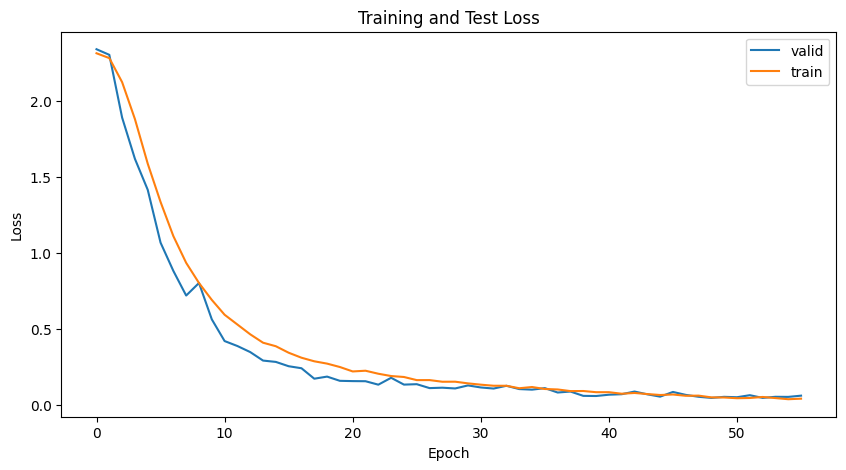

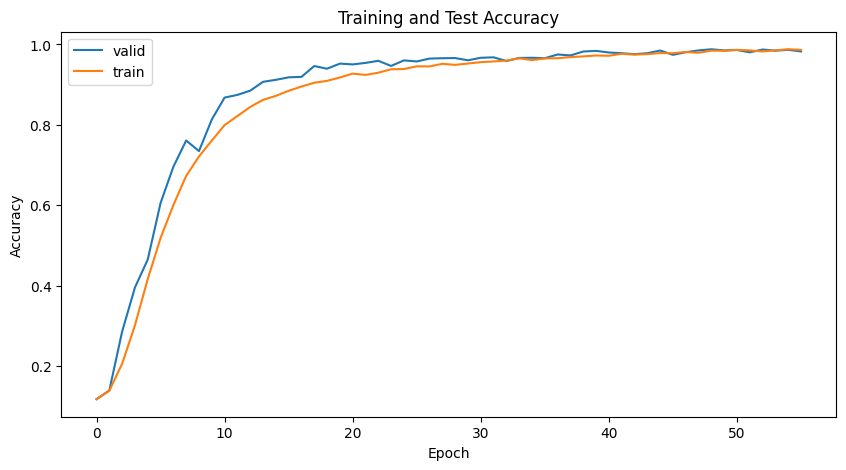

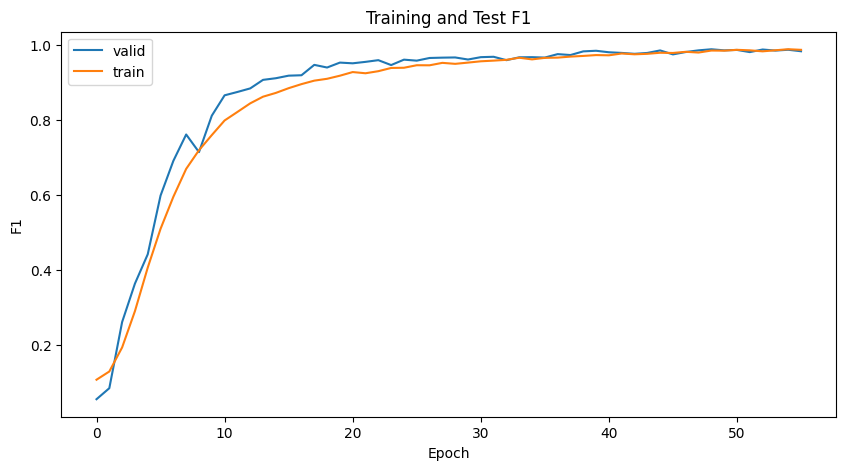

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    elif model_name == 'vit_lite32' or model_name == 'vit_lite16':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:46<00:00,  3.60it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)